In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./dataset/zgpa_train.csv')
df.info()
df.sort_values('date')
df.head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    731 non-null    object 
 1   open    731 non-null    float64
 2   high    731 non-null    float64
 3   low     731 non-null    float64
 4   close   731 non-null    float64
 5   volume  731 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 34.4+ KB


<bound method NDFrame.head of            date   open   high    low  close    volume
0    2016-01-04  30.57  30.57  28.63  28.78  70997200
1    2016-01-05  28.41  29.54  28.23  29.23  87498504
2    2016-01-06  29.03  29.39  28.73  29.26  48012112
3    2016-01-07  28.73  29.25  27.73  28.50  23647604
4    2016-01-08  28.73  29.18  27.63  28.67  98239664
..          ...    ...    ...    ...    ...       ...
726  2018-12-24  56.15  56.45  55.90  56.40  35874840
727  2018-12-25  55.69  56.93  55.03  56.36  66463320
728  2018-12-26  56.32  56.40  55.35  55.45  39782132
729  2018-12-27  56.43  56.53  55.05  55.05  75189048
730  2018-12-28  55.15  55.38  54.25  54.25  91498808

[731 rows x 6 columns]>

(731, 6)


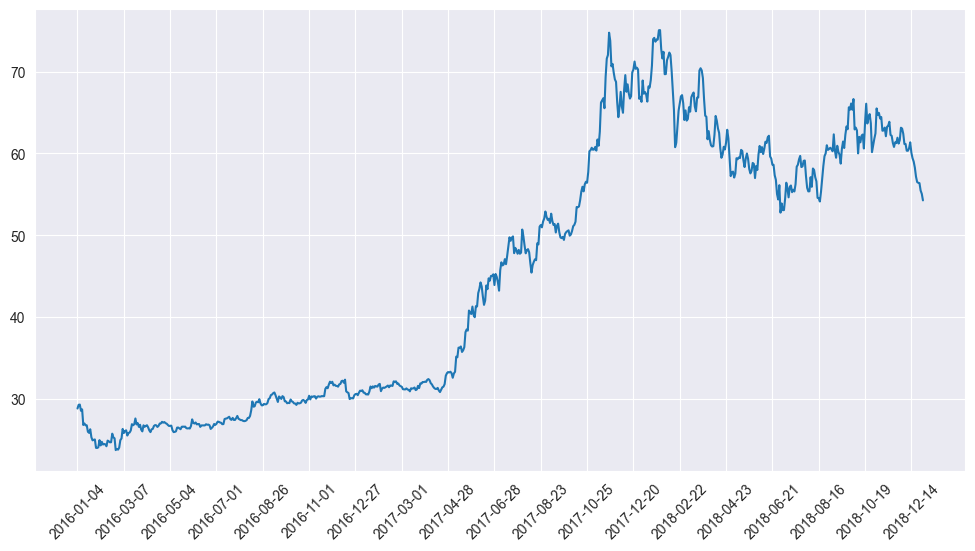

In [3]:
print(df.shape)
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
plt.plot(df[['close']])
plt.xticks(range(0,df.shape[0],40),df['date'].loc[::40],rotation=45)
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1,1))

print(df['close'])

0     -0.801946
1     -0.784436
2     -0.783268
3     -0.812840
4     -0.806226
         ...   
726    0.272763
727    0.271206
728    0.235798
729    0.220233
730    0.189105
Name: close, Length: 731, dtype: float64


In [5]:
def split_data(stock,lookback):
    data_raw = stock.to_numpy()
    data = []
    
    for i in range(len(data_raw)-lookback):
        data.append(data_raw[i:i+lookback])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0]-test_set_size
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_test = data[test_set_size:,:-1,:]
    y_test = data[test_set_size:,-1,:]
    return [x_train,y_train,x_test,y_test]


lookback = 20
x_train,y_train,x_test,y_test = split_data(df[['close']],lookback)
print(x_train.shape)    
print(y_train.shape)    
print(x_test.shape)    
print(y_test.shape)    

(569, 19, 1)
(569, 1)
(569, 19, 1)
(569, 1)


In [6]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [7]:
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim,output_dim)
        
    def forward(self,x):
        h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        out = self.fc(out[:,-1,:])
        return out

In [8]:
input_dim = 1
output_dim = 1
num_epochs = 100
hidden_dim = 32
num_layers = 2

model = LSTM(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)
critierion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.01)


In [9]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for i in range(num_epochs):
    y_train_pred = model(x_train)
    loss = critierion(y_train_pred,y_train_lstm)
    print('Epoch ',i,'MSE: ',loss.item())
    hist[i] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print('Training time:{}'.format(training_time))

Epoch  0 MSE:  0.4652203619480133
Epoch  1 MSE:  0.38567766547203064
Epoch  2 MSE:  0.32272082567214966
Epoch  3 MSE:  0.29269954562187195
Epoch  4 MSE:  0.24380218982696533
Epoch  5 MSE:  0.16437868773937225
Epoch  6 MSE:  0.10440976172685623
Epoch  7 MSE:  0.06164184585213661
Epoch  8 MSE:  0.056224990636110306
Epoch  9 MSE:  0.06681624054908752
Epoch  10 MSE:  0.07382427155971527
Epoch  11 MSE:  0.04731762409210205
Epoch  12 MSE:  0.044323477894067764
Epoch  13 MSE:  0.031630970537662506
Epoch  14 MSE:  0.017878543585538864
Epoch  15 MSE:  0.019696228206157684
Epoch  16 MSE:  0.018520759418606758
Epoch  17 MSE:  0.01242053508758545
Epoch  18 MSE:  0.007923233322799206
Epoch  19 MSE:  0.008486071601510048
Epoch  20 MSE:  0.01093356218189001
Epoch  21 MSE:  0.011254461482167244
Epoch  22 MSE:  0.010323832742869854
Epoch  23 MSE:  0.010349679738283157
Epoch  24 MSE:  0.011234329082071781
Epoch  25 MSE:  0.012230167165398598
Epoch  26 MSE:  0.01249005924910307
Epoch  27 MSE:  0.01139772

In [10]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

Text(0.5, 0, 'Epoch')

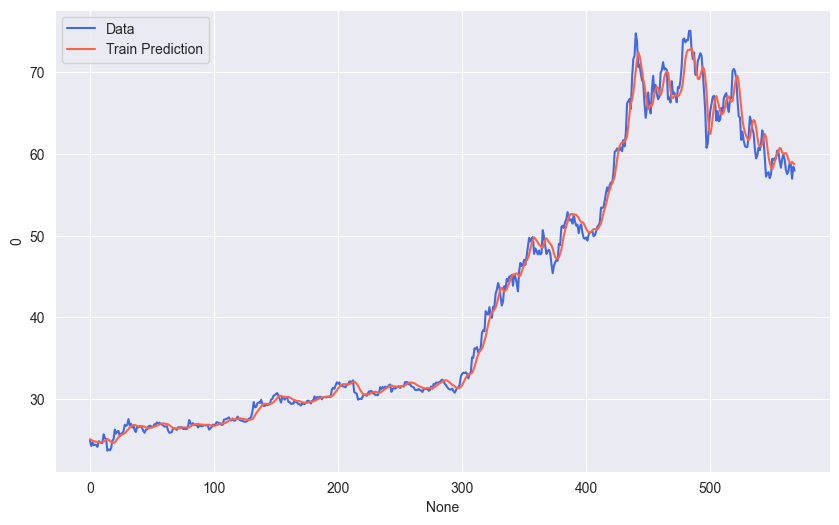

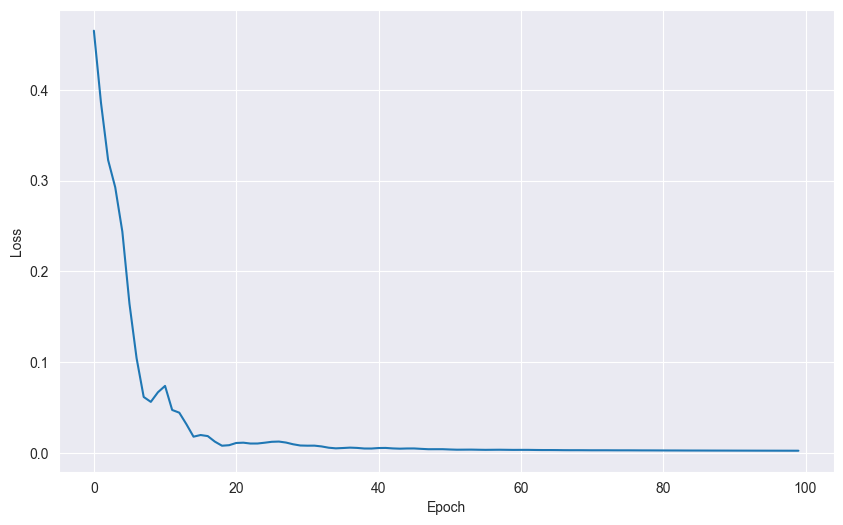

In [11]:
import seaborn as sns
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(x=original.index,y=original[0],label='Data',color='royalblue')
ax = sns.lineplot(x=predict.index,y=predict[0],label='Train Prediction',color='tomato')

fig = plt.figure(figsize=(10,6))
ax = sns.lineplot(data = hist)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')